In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

np.set_printoptions(precision=3)

import os
import pickle
import random
from collections import deque
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
class Agent:
    def __init__(self, env, gamma=0.9, epsilon=0.1, lr=0.001, batch_size=32):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.lr = lr
        
        self.state_dim = 13 
        self.action_dim = 5
        
        self.Q = Net(self.state_dim, self.action_dim)
        self.Q_target = deepcopy(self.Q)  
        
        self.optimizer = optim.Adam(self.Q.parameters(), lr=lr)
        self.memory = deque(maxlen=10000)

        self.r_history = []
        self.r_per_radius_history = []

        self.episodes_trained = 0
        self.current_episode = 0

    
    def act(self, state):
        # Simple-minded agent that always select action 1
        return 1
    
    def epsilon_greedy_policy(self, state):
        epsilon = 1 - min(self.current_episode, 1000)/(min(self.episodes_trained, 1000)+1)
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_dim)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                return torch.argmax(self.Q(state_tensor)).item()
            
    def greedy_policy(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.Q(state_tensor)).item()
            
    def soft_update(self, tau=0.01):
        with torch.no_grad():
            for target_param, param in zip(self.Q_target.parameters(), self.Q.parameters()):
                target_param += tau * (param - target_param)

    def train(self, num_episodes):

        self.episodes_trained += num_episodes

        for episode in tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            r_total = 0
            while not done:
                if state[-1] < 0.75 or state[-1] >= 161.75:
                    action = self.epsilon_greedy_policy(state)
                    reward, next_state, done, velocity = self.env.transition(action)
                    state = next_state
                    r_total += reward
                else:
                    action = self.epsilon_greedy_policy(state)
                    reward, next_state, done, velocity = self.env.one_lap_transition(action) # target aim at state 1 lap ahead
                    self.memory.append(
                        (state, action, reward, next_state, done)
                    )
                    if len(self.memory) >= self.batch_size:
                        self.replay()
                    state = next_state
                    r_total += reward
            self.r_history.append(r_total)
            self.r_per_radius_history.append(r_total/self.env.radius)
            self.current_episode += 1
    
    def replay(self):
        batch = random.choices(
            self.memory, k = self.batch_size
        )
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(states).to(torch.float32)
        actions = torch.tensor(actions).to(torch.int64)
        rewards = torch.tensor(rewards).to(torch.float32)
        next_states = torch.tensor(next_states).to(torch.float32)
        dones = torch.tensor(dones).to(torch.int16)
        
        current_q = self.Q(states)   # across all possible actions
        current_q = current_q.gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        next_q = self.Q_target(next_states).max(1)[0]
        targets = rewards + (self.gamma * next_q * (1 - dones))
        loss = nn.MSELoss()(current_q, targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update()

    def plot_rewards(self):
        plt.plot(self.r_history, label=f"gamma: {self.gamma} - lr: {self.lr}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    def plot_cumulative_rewards(self):
        avg = 0
        avg_cumulative = []
        for n, i in enumerate(self.r_history):
            avg = (avg*n + i)/(n + 1)
            avg_cumulative.append(avg)
        plt.plot(avg_cumulative, label=f"gamma: {self.gamma} - lr: {self.lr}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    def plot_rewards_per_radius(self):
        plt.plot(self.r_per_radius_history, label=f"gamma: {self.gamma} - lr: {self.lr}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    def plot_cumulative_rewards_per_radius(self):
        avg = 0
        avg_cumulative = []
        for n, i in enumerate(self.r_per_radius_history):
            avg = (avg*n + i)/(n + 1)
            avg_cumulative.append(avg)
        plt.plot(avg_cumulative, label=f"gamma: {self.gamma} - lr: {self.lr}")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    def state_dict(self, number_to_add):
        for k in self.__dict__:
            setattr(self, k, getattr(self, k) + number_to_add)
        return self
    
    def save_agent(self, name):
        checkpoint = { 
            "env": self.env,
            "gamma": self.gamma,
            "epsilon": self.epsilon,
            "batch_size": self.batch_size,
            "lr": self.lr,
            "state_dim": self.state_dim,
            "action_dim": self.action_dim,
            "Q": self.Q,
            "Q_target": self.Q_target,
            "optimizer": self.optimizer,
            "memory": self.memory,
            "r_history": self.r_history,
            "r_per_radius_history": self.r_per_radius_history,
            "episodes_trained": self.episodes_trained,
            "current_episode": self.current_episode,
        }
        torch.save(checkpoint, name)

    def load_agent(self, name):
        checkpoint = torch.load(name)
        for k, v in self.__dict__.items():
            self.__dict__[k] = checkpoint[k]


In [4]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

    
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self, evaluation=False):
        if evaluation:
            self.radius = 900
        else:
            self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    def _get_state(self):
        # one hot encoding for current tyres and weather
        state = [0.0,0.0,0.0,0.0,self.car.condition,0.0,0.0,0.0,0.0,0.0,0.0, self.radius, self.laps_cleared]
        state[self.car.possible_tyres.index(self.car.tyre)] = 1.0
        state[self.possible_weather.index(self.cur_weather)+5] = 1.0
            
        return state
        
    
    def transition(self, action=0, weather_sequence=None, j=None):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        if weather_sequence:
            self.cur_weather = str(weather_sequence[j])
        else:
            self.cur_weather = np.random.choice(
                self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
            )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()

        return reward, next_state, self.is_done, velocity
    
    def one_lap_transition(self, action=0, weather_sequence=None, j=None):
        total_rewards = 0
        for _ in range(8):
            if weather_sequence:
                reward, next_state, done, velocity = self.transition(action=action, weather_sequence=weather_sequence, j=j)
                total_rewards += reward
                next_state = self._get_state()
                j += 1
            else:
                reward, next_state, done, velocity = self.transition(action)
                total_rewards += reward
                next_state = self._get_state()

        return total_rewards, next_state, self.is_done, velocity

#### Grid Search

In [5]:
new_car = Car()
env = Track(new_car)
num_episodes = 2000
gammas = [0.5,0.7,0.9]
lrs = [0.1,0.01,0.001]

for gamma in gammas:
    for lr in lrs:
        agent = Agent(env, gamma=gamma, lr=lr, batch_size=32)
        agent.train(num_episodes=num_episodes)
        agent.save_agent(name=f"./Agents/agent_gamma{gamma}_lr{lr}_episodes{num_episodes}.pth")

100%|██████████| 2000/2000 [27:32<00:00,  1.21it/s]


#### Plot training results

Best agents were trained for more episodes

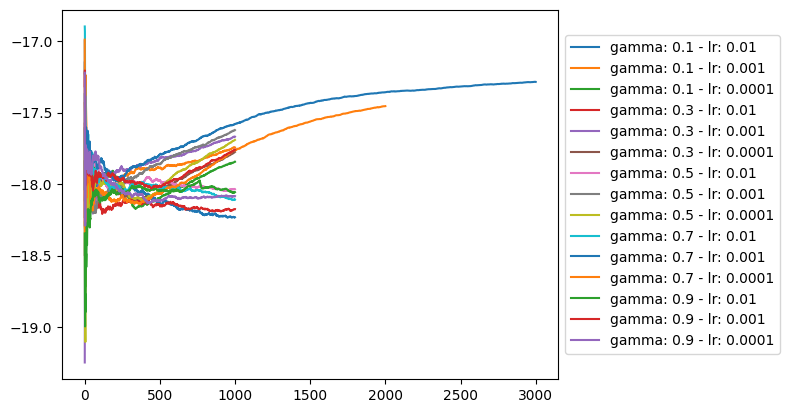

In [11]:
new_car = Car()
env = Track(new_car)

num_episodes = 1000

for gamma in [0.1,0.3,0.5,0.7,0.9]:
    for lr in [0.01,0.001, 0.0001]:
        agent = Agent(env, gamma=gamma, lr=lr, batch_size=32)
        agent.load_agent(name=f"./Agents/agent_gamma{gamma}_lr{lr}_episodes{num_episodes}.pth")
        agent.plot_cumulative_rewards_per_radius()

#### Final agent: 
<br>gamma 0.7
<br>learning rate 0.001
<br>trained for 2000 episodes
<br>saved as "agent_gamma0.7_lr0.001_episodes2000_redo.pth"

### Eval

<br> import evaluation class for fixed weather configurations
<br> saved final results in csv

In [12]:
from project_helper_v1 import DQNEvaluationTrack
import pickle
import pandas as pd

In [14]:
new_car = Car()
results = pd.DataFrame(columns=['Weather Config','Radius','Rewards'])
model_log = pd.DataFrame(columns=['model_name', 'wc', 'tyre', 'tyre_condition', 'weather_condition', 'radius', 'lap', 'velocity', 'reward'])

G_list = []
j=0
for i in range(81):
    G = 0
    env = DQNEvaluationTrack(car=new_car, weather_config=i, config_fp="weather configuratons.pickle")
    state = env.reset()   
    done = False
    agent = Agent(env)
    agent.load_agent(name=f"./Agents/agent_gamma0.7_lr0.001_episodes2000_redo.pth")
    while not done:
        action = agent.greedy_policy(state)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward

        tyre = np.argmax(state[0:4])
        tyre_condition = state[4]
        weather_condition = np.argmax(state[5:11])
        radius = state[11]
        lap = state[12]

        model_log.loc[j, "model_name"] = "DQN"
        model_log.loc[j, "wc"] = i
        model_log.loc[j, "tyre"] = tyre
        model_log.loc[j, "tyre_condition"] = tyre_condition
        model_log.loc[j, "weather_condition"] = weather_condition
        model_log.loc[j, "radius"] = radius
        model_log.loc[j, "lap"] = lap
        model_log.loc[j, "velocity"] = velocity
        model_log.loc[j, "reward"] = reward
        j+=1
    
    results.loc[i, "Weather Config"] = i
    results.loc[i, "Radius"] = env.radius
    results.loc[i, "Rewards"] = G

# model_log.to_csv("./dqn_model_log.csv", index=False)
results.to_csv("./eval_dqn.csv", index=False)